In [14]:
INPUT_WINDOW = 12 # one year of data
MODEL_NAME = 'sklearn-custom-model-example'
PROFILE = 'render_notebook'
LOG_LEVEL = 'INFO'
MODEL_NAME

'sklearn-custom-model-example'

In [15]:
## requirements
# conda install --file env/byoml_sklearn.environment.yml
# conda activate byoml_sklearn 
# pip install -r env/byoml_sklearn.requirements.txt

## Custom model

It is also possible to build your own custom model and upload it. For example when custom pre- or postprocessing is needed. The libraries you can use are:
- `numpy`
- `pandas`
- `sklearn`

We use `dill` to serialize the model.

Let's create a custom forecaster using a RandomForestRegressor:

In [16]:
import seaborn as sns
import pandas as pd
import math
import numpy as np
if LOG_LEVEL:
    import logging
    logging.basicConfig(level=LOG_LEVEL)

passengers                                                       
month        Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
year                                                                   
1949         112  118  132  129  121  135  148  148  136  119  104  118
1950         115  126  141  135  125  149  170  170  158  133  114  140
1951         145  150  178  163  172  178  199  199  184  162  146  166
1952         171  180  193  181  183  218  230  242  209  191  172  194
1953         196  196  236  235  229  243  264  272  237  211  180  201
1954         204  188  235  227  234  264  302  293  259  229  203  229
1955         242  233  267  269  270  315  364  347  312  274  237  278
1956         284  277  317  313  318  374  413  405  355  306  271  306
1957         315  301  356  348  355  422  465  467  404  347  305  336
1958         340  318  362  348  363  435  491  505  404  359  310  337
1959         360  342  406  396  420  472  548  559  463  407  362  405
1960         417  391  419  461  472  535  622  606  508  461  390  432

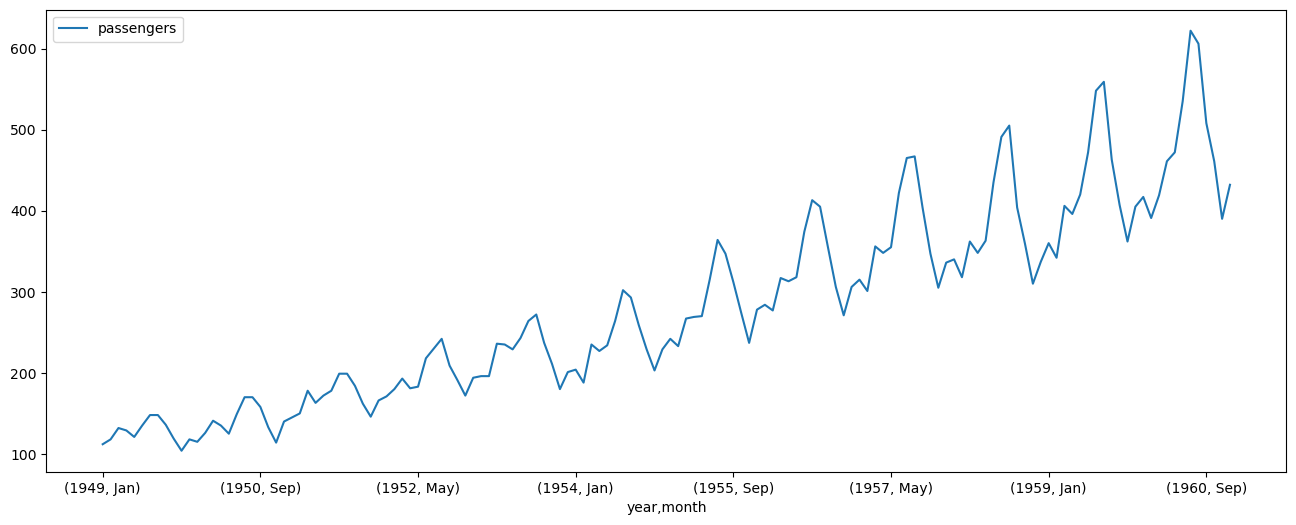

In [17]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

We define the following utility to extract features and labels for our prediction model.

In [18]:
def create_X_y(input_data, window=INPUT_WINDOW):
    X = []
    y = []
    for i in range(len(input_data)-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window]
        X.append(train_seq)
        y.append(train_label)
    return np.array(X), np.array(y)

Now we can create our custom model, where we should keep a couple of things in mind:
- The class should have a `predict` method similar to `sklearn`
- The class should return a numpy array, again similar to `sklearn`
- It is best practice to also expect the incoming data to be similar to `sklearn`, in other words an array of feature sets

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
# we don't need fit this one as we will fit on newly arriving data and output a forecast of 1 year for that
class Forecaster:
    
    def __init__(self, window=INPUT_WINDOW):
        self.window = window
        
    def predict(self, data):
        predictions = []
        
        # this is an sklearn convention where data is an array of feature sets, so we keep that convention
        feature_set = data[0]
        model = RandomForestRegressor()

        window = self.window
        X, y = create_X_y(feature_set, window)
        model.fit(X, y)
    
        # shift the window each time by 1
        to_predict = feature_set[-window:]
        for i in range(self.window):
            model_input = to_predict[i:i+window]
            preds = model.predict([model_input])
            to_predict = np.append(to_predict, preds)

        return np.array(to_predict[-window:]) # custom models should always return a numpy array

In [21]:
test_data = df.loc[:(1959,'Dec'),'passengers'].values
model = Forecaster(INPUT_WINDOW)
preds = model.predict([test_data])

<AxesSubplot:xlabel='year,month'>

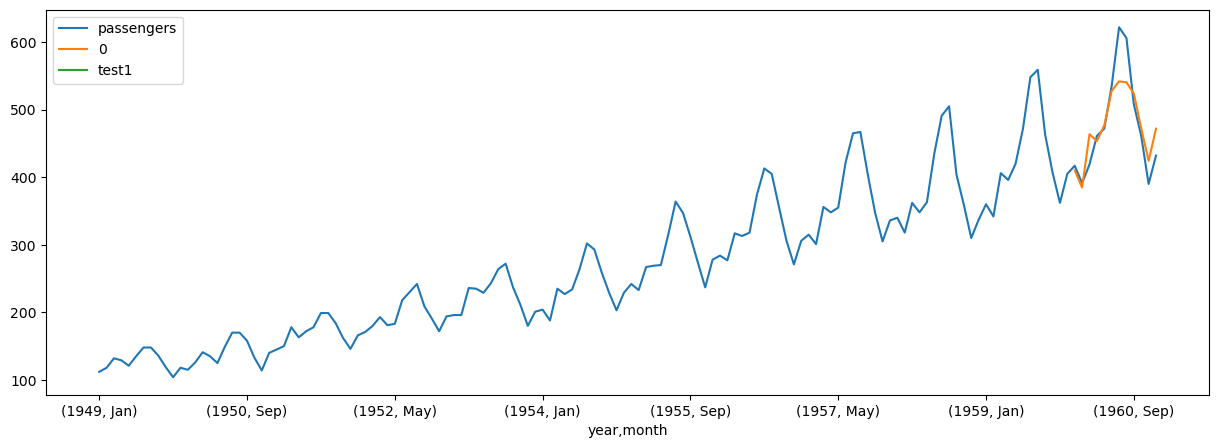

In [22]:
df_pred = df.copy()

# extend index with windows year
next_year = int(df.index.levels[0][-1])+1
for year in range(next_year, next_year + math.ceil(INPUT_WINDOW/12)):
    for month in df.index.levels[1]:
        df_pred.loc[(year, month),0] = np.NaN

df_pred['test1'] = np.NaN
df_pred.iloc[len(test_data):len(test_data)+len(preds),1] = preds
df_pred.plot(figsize=(15, 5))

## Upload BYOML model

In [23]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile(PROFILE)

In [37]:
import time
# clean up existing model
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
    time.sleep(5) # takes a while to have name available again
except RestResponseError as e:
    display(f'Ignored: {e}')

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=DELETE;status_code=200;dur=279.190


'Removed: sklearn-custom-model-example'

Now we can save the custom model using the `dill` library and upload it to Waylay. 
Because this case requires a custom serialization method, we pass a file with
the serialized model into `byoml.model.upload`, instead of model object.


In [39]:
import tempfile
import dill

with tempfile.TemporaryDirectory() as tmp_dir:
    model_file = f'{tmp_dir}/model.joblib'
    
    with open(model_file, 'wb') as f:
        dill.settings['recurse']=True
        dill.dump(model, f)
        
    waylay.byoml.model.upload(
        model_name=MODEL_NAME, 
        trained_model=model_file, # a model file with custom serialization, instead of the model object
        framework='sklearn', # as we use sklearn conventions here, we should set that one as our framework 
        description='custom sklearn example'
    )        


INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=4323.237


In [40]:
waylay.byoml.model.get(MODEL_NAME, params=dict(debug=True))

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=GET;status_code=200;dur=2021.875


{'createdBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'createdOn': '2022-09-06T10:34:53.331000+00:00',
 'description': 'custom sklearn example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'metadata': {'description': 'custom sklearn example'},
 'name': 'sklearn-custom-model-example',
 'ready': False,
 'runtime': {'framework': 'sklearn',
  'framework_version': '0.24',
  'name': 'byoml-sklearn-0.24',
  'python_version': '3.7'},
 'semantic_version': '0.0.1',
 'serving_name': 'kf-3e5ce02e3cc8a5a7957e8d28a75e584a0cef05a2.openfaas-fn-66417857-9f49-4a83-9307-e12ad5fbda45',
 'status': 'running',
 'supported_endpoints': [],
 'updatedBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'updatedOn': '2022-09-06T10:34:57.387000+00:00',
 'version': '1'}

In [41]:
result = waylay.byoml.model.predict(MODEL_NAME, [test_data.tolist()])

result

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=15925.369
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=15940.908


[407.74,
 378.49,
 466.14,
 453.55,
 484.88,
 521.25,
 533.95,
 538.73,
 519.06,
 477.91,
 422.6,
 475.92]

In [42]:
waylay.byoml.model.remove(MODEL_NAME)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=DELETE;status_code=200;dur=144.216


{'message': 'Model sklearn-custom-model-example: all versions deleted',
 'name': 'sklearn-custom-model-example',
 'versions': ['0.0.1']}